# Análise exploratória de dados Pub Med e Tweet Covid19

## Instalação dos pacotes necessários para EDA

In [ ]:
# Executar esse bloco caso não tenha o pacote instalado
# install.packages("tidyverse")
# install.packages("magrittr")
# install.packages("tm")
# install.packages("wordcloud")

## Carregando os pacotes

In [1]:
library(wordcloud)
library(magrittr)
library(tm)
library(tidyverse)
library(tidyr)
library(cluster)

Loading required package: RColorBrewer

Loading required package: NLP

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::annotate() masks NLP::annotate()
✖ tidyr::extract()    masks magrittr::extract()
✖ dplyr::filter()     masks stats::filter()
✖ dplyr::lag()        masks stats::lag()
✖ purrr::set_names()  masks magrittr::set_names()



## Leitura dos dados Pub Med

In [2]:
# Leitura do arquivo por linha
covid <- readLines("PM-COVID-4064-TM.txt")

In [3]:
# Leitura do arquivo por DF
covid_df <- read.delim("PM-COVID-4064-TM.txt", header = FALSE, sep = "\n")
covid_df$doc_id <- seq.int(nrow(covid_df))
covid_df <- covid_df[,c(2,1)]
colnames(covid_df) <- c("doc_id", "text")

In [4]:
covid_source <- VectorSource(covid)
coviddf_source <- DataframeSource(covid_df)

In [5]:
covid_corpus <- VCorpus(covid_source)
coviddf_corpus <- VCorpus(coviddf_source)

In [6]:
print(covid_corpus)
print(coviddf_corpus)
covid_corpus[[1]]
covid_corpus[[1]]$content

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 3767
<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 2647


<<PlainTextDocument>>
Metadata:  7
Content:  chars: 1648

[1] "The World Health Organization (WHO) has issued a warning that, although the 2019  novel coronavirus (COVID-19) from Wuhan City (China), is not pandemic, it should be  contained to prevent the global spread. The COVID-19 virus was known earlier as  2019-nCoV. As of 12 February 2020, WHO reported 45,171 cases and 1115 deaths related  to COVID-19. COVID-19 is similar to Severe Acute Respiratory Syndrome coronavirus  (SARS-CoV) virus in its pathogenicity, clinical spectrum, and epidemiology.  Comparison of the genome sequences of COVID-19, SARS-CoV, and Middle East  Respiratory Syndrome coronavirus (MERS-CoV) showed that COVID-19 has a better  sequence identity with SARS-CoV compared to MERS CoV. However, the amino acid  sequence of COVID-19 differs from other coronaviruses specifically in the regions of  1ab polyprotein and surface glycoprotein or S-protein. Although several animals have  been speculated to be a reservoir for COVID-19, no animal reservoir has been already  confirmed. COVID-19 causes COVID-19 disease that has similar symptoms as SARS-CoV.  Studies suggest that the human receptor for COVID-19 may be angiotensin-converting  enzyme 2 (ACE2) receptor similar to that of SARS-CoV. The nucleocapsid (N) protein  of COVID-19 has nearly 90% amino acid sequence identity with SARS-CoV. The N protein  antibodies of SARS-CoV may cross react with COVID-19 but may not provide  cross-immunity. In a similar fashion to SARS-CoV, the N protein of COVID-19 may play  an important role in suppressing the RNA interference (RNAi) to overcome the host  defense. This mini-review aims at investigating the most recent trend of COVID-19."

## Limpeza dos dados Pub Med

In [7]:
# Lista de stopwords en, pt e es
stopwords("en"); stopwords("pt"); stopwords("es")

[1] "i"          "me"         "my"         "myself"     "we"        
  [6] "our"        "ours"       "ourselves"  "you"        "your"      
 [11] "yours"      "yourself"   "yourselves" "he"         "him"       
 [16] "his"        "himself"    "she"        "her"        "hers"      
 [21] "herself"    "it"         "its"        "itself"     "they"      
 [26] "them"       "their"      "theirs"     "themselves" "what"      
 [31] "which"      "who"        "whom"       "this"       "that"      
 [36] "these"      "those"      "am"         "is"         "are"       
 [41] "was"        "were"       "be"         "been"       "being"     
 [46] "have"       "has"        "had"        "having"     "do"        
 [51] "does"       "did"        "doing"      "would"      "should"    
 [56] "could"      "ought"      "i'm"        "you're"     "he's"      
 [61] "she's"      "it's"       "we're"      "they're"    "i've"      
 [66] "you've"     "we've"      "they've"    "i'd"        "you'd"     
 [71] "he'd"       "she'd"      "we'd"       "they'd"     "i'll"      
 [76] "you'll"     "he'll"      "she'll"     "we'll"      "they'll"   
 [81] "isn't"      "aren't"     "wasn't"     "weren't"    "hasn't"    
 [86] "haven't"    "hadn't"     "doesn't"    "don't"      "didn't"    
 [91] "won't"      "wouldn't"   "shan't"     "shouldn't"  "can't"     
 [96] "cannot"     "couldn't"   "mustn't"    "let's"      "that's"    
[101] "who's"      "what's"     "here's"     "there's"    "when's"    
[106] "where's"    "why's"      "how's"      "a"          "an"        
[111] "the"        "and"        "but"        "if"         "or"        
[116] "because"    "as"         "until"      "while"      "of"        
[121] "at"         "by"         "for"        "with"       "about"     
[126] "against"    "between"    "into"       "through"    "during"    
[131] "before"     "after"      "above"      "below"      "to"        
[136] "from"       "up"         "down"       "in"         "out"       
[141] "on"         "off"        "over"       "under"      "again"     
[146] "further"    "then"       "once"       "here"       "there"     
[151] "when"       "where"      "why"        "how"        "all"       
[156] "any"        "both"       "each"       "few"        "more"      
[161] "most"       "other"      "some"       "such"       "no"        
[166] "nor"        "not"        "only"       "own"        "same"      
[171] "so"         "than"       "too"        "very"

[1] "de"           "a"            "o"            "que"          "e"           
  [6] "do"           "da"           "em"           "um"           "para"        
 [11] "com"          "não"          "uma"          "os"           "no"          
 [16] "se"           "na"           "por"          "mais"         "as"          
 [21] "dos"          "como"         "mas"          "ao"           "ele"         
 [26] "das"          "à"            "seu"          "sua"          "ou"          
 [31] "quando"       "muito"        "nos"          "já"           "eu"          
 [36] "também"       "só"           "pelo"         "pela"         "até"         
 [41] "isso"         "ela"          "entre"        "depois"       "sem"         
 [46] "mesmo"        "aos"          "seus"         "quem"         "nas"         
 [51] "me"           "esse"         "eles"         "você"         "essa"        
 [56] "num"          "nem"          "suas"         "meu"          "às"          
 [61] "minha"        "numa"         "pelos"        "elas"         "qual"        
 [66] "nós"          "lhe"          "deles"        "essas"        "esses"       
 [71] "pelas"        "este"         "dele"         "tu"           "te"          
 [76] "vocês"        "vos"          "lhes"         "meus"         "minhas"      
 [81] "teu"          "tua"          "teus"         "tuas"         "nosso"       
 [86] "nossa"        "nossos"       "nossas"       "dela"         "delas"       
 [91] "esta"         "estes"        "estas"        "aquele"       "aquela"      
 [96] "aqueles"      "aquelas"      "isto"         "aquilo"       "estou"       
[101] "está"         "estamos"      "estão"        "estive"       "esteve"      
[106] "estivemos"    "estiveram"    "estava"       "estávamos"    "estavam"     
[111] "estivera"     "estivéramos"  "esteja"       "estejamos"    "estejam"     
[116] "estivesse"    "estivéssemos" "estivessem"   "estiver"      "estivermos"  
[121] "estiverem"    "hei"          "há"           "havemos"      "hão"         
[126] "houve"        "houvemos"     "houveram"     "houvera"      "houvéramos"  
[131] "haja"         "hajamos"      "hajam"        "houvesse"     "houvéssemos" 
[136] "houvessem"    "houver"       "houvermos"    "houverem"     "houverei"    
[141] "houverá"      "houveremos"   "houverão"     "houveria"     "houveríamos" 
[146] "houveriam"    "sou"          "somos"        "são"          "era"         
[151] "éramos"       "eram"         "fui"          "foi"          "fomos"       
[156] "foram"        "fora"         "fôramos"      "seja"         "sejamos"     
[161] "sejam"        "fosse"        "fôssemos"     "fossem"       "for"         
[166] "formos"       "forem"        "serei"        "será"         "seremos"     
[171] "serão"        "seria"        "seríamos"     "seriam"       "tenho"       
[176] "tem"          "temos"        "tém"          "tinha"        "tínhamos"    
[181] "tinham"       "tive"         "teve"         "tivemos"      "tiveram"     
[186] "tivera"       "tivéramos"    "tenha"        "tenhamos"     "tenham"      
[191] "tivesse"      "tivéssemos"   "tivessem"     "tiver"        "tivermos"    
[196] "tiverem"      "terei"        "terá"         "teremos"      "terão"       
[201] "teria"        "teríamos"     "teriam"

[1] "de"           "la"           "que"          "el"           "en"          
  [6] "y"            "a"            "los"          "del"          "se"          
 [11] "las"          "por"          "un"           "para"         "con"         
 [16] "no"           "una"          "su"           "al"           "lo"          
 [21] "como"         "más"          "pero"         "sus"          "le"          
 [26] "ya"           "o"            "este"         "sí"           "porque"      
 [31] "esta"         "entre"        "cuando"       "muy"          "sin"         
 [36] "sobre"        "también"      "me"           "hasta"        "hay"         
 [41] "donde"        "quien"        "desde"        "todo"         "nos"         
 [46] "durante"      "todos"        "uno"          "les"          "ni"          
 [51] "contra"       "otros"        "ese"          "eso"          "ante"        
 [56] "ellos"        "e"            "esto"         "mí"           "antes"       
 [61] "algunos"      "qué"          "unos"         "yo"           "otro"        
 [66] "otras"        "otra"         "él"           "tanto"        "esa"         
 [71] "estos"        "mucho"        "quienes"      "nada"         "muchos"      
 [76] "cual"         "poco"         "ella"         "estar"        "estas"       
 [81] "algunas"      "algo"         "nosotros"     "mi"           "mis"         
 [86] "tú"           "te"           "ti"           "tu"           "tus"         
 [91] "ellas"        "nosotras"     "vosotros"     "vosotras"     "os"          
 [96] "mío"          "mía"          "míos"         "mías"         "tuyo"        
[101] "tuya"         "tuyos"        "tuyas"        "suyo"         "suya"        
[106] "suyos"        "suyas"        "nuestro"      "nuestra"      "nuestros"    
[111] "nuestras"     "vuestro"      "vuestra"      "vuestros"     "vuestras"    
[116] "esos"         "esas"         "estoy"        "estás"        "está"        
[121] "estamos"      "estáis"       "están"        "esté"         "estés"       
[126] "estemos"      "estéis"       "estén"        "estaré"       "estarás"     
[131] "estará"       "estaremos"    "estaréis"     "estarán"      "estaría"     
[136] "estarías"     "estaríamos"   "estaríais"    "estarían"     "estaba"      
[141] "estabas"      "estábamos"    "estabais"     "estaban"      "estuve"      
[146] "estuviste"    "estuvo"       "estuvimos"    "estuvisteis"  "estuvieron"  
[151] "estuviera"    "estuvieras"   "estuviéramos" "estuvierais"  "estuvieran"  
[156] "estuviese"    "estuvieses"   "estuviésemos" "estuvieseis"  "estuviesen"  
[161] "estando"      "estado"       "estada"       "estados"      "estadas"     
[166] "estad"        "he"           "has"          "ha"           "hemos"       
[171] "habéis"       "han"          "haya"         "hayas"        "hayamos"     
[176] "hayáis"       "hayan"        "habré"        "habrás"       "habrá"       
[181] "habremos"     "habréis"      "habrán"       "habría"       "habrías"     
[186] "habríamos"    "habríais"     "habrían"      "había"        "habías"      
[191] "habíamos"     "habíais"      "habían"       "hube"         "hubiste"     
[196] "hubo"         "hubimos"      "hubisteis"    "hubieron"     "hubiera"     
[201] "hubieras"     "hubiéramos"   "hubierais"    "hubieran"     "hubiese"     
[206] "hubieses"     "hubiésemos"   "hubieseis"    "hubiesen"     "habiendo"    
[211] "habido"       "habida"       "habidos"      "habidas"      "soy"         
[216] "eres"         "es"           "somos"        "sois"         "son"         
[221] "sea"          "seas"         "seamos"       "seáis"        "sean"        
[226] "seré"         "serás"        "será"         "seremos"      "seréis"      
[231] "serán"        "sería"        "serías"       "seríamos"     "seríais"     
[236] "serían"       "era"          "eras"         "éramos"       "erais"       
[241] "eran"         "fui"          "fuiste"       "fue"          "fuimos"      
[246] "fuisteis"     "fueron"    

In [2]:
new_stops <- c("COVID", "the", "The", stopwords("en"))

## Aplicando a limpeza e normalização dos dados em toda base Pub Med

In [9]:
covid_clean <- tm_map(covid_corpus, removeWords, words = c(new_stops))
covid_clean <- tm_map(covid_clean, removePunctuation)
covid_clean[[1]]$content
covid_clean <- tm_map(covid_clean, stripWhitespace)

[1] " World Health Organization WHO  issued  warning  although  2019  novel coronavirus 19  Wuhan City China   pandemic     contained  prevent  global spread  19 virus  known earlier   2019nCoV As  12 February 2020 WHO reported 45171 cases  1115 deaths related   19 19  similar  Severe Acute Respiratory Syndrome coronavirus  SARSCoV virus   pathogenicity clinical spectrum  epidemiology  Comparison   genome sequences  19 SARSCoV  Middle East  Respiratory Syndrome coronavirus MERSCoV showed  19   better  sequence identity  SARSCoV compared  MERS CoV However  amino acid  sequence  19 differs   coronaviruses specifically   regions   1ab polyprotein  surface glycoprotein  Sprotein Although several animals    speculated    reservoir  19  animal reservoir   already  confirmed 19 causes 19 disease   similar symptoms  SARSCoV  Studies suggest   human receptor  19 may  angiotensinconverting  enzyme 2 ACE2 receptor similar    SARSCoV  nucleocapsid N protein   19  nearly 90 amino acid sequence identity  SARSCoV  N protein  antibodies  SARSCoV may cross react  19  may  provide  crossimmunity In  similar fashion  SARSCoV  N protein  19 may play   important role  suppressing  RNA interference RNAi  overcome  host  defense This minireview aims  investigating   recent trend  19"

## Frequência dos Termos Pub Med 

In [10]:
covid_dtm <- DocumentTermMatrix(covid_clean)
covid_dtm
covid_m1 <- as.matrix(covid_dtm)

<<DocumentTermMatrix (documents: 3767, terms: 23136)>>
Non-/sparse entries: 337733/86815579
Sparsity           : 100%
Maximal term length: 108
Weighting          : term frequency (tf)

In [11]:
covid_tdm <- TermDocumentMatrix(covid_clean)
covid_tdm
covid_m2 <- as.matrix(covid_tdm)

<<TermDocumentMatrix (terms: 23136, documents: 3767)>>
Non-/sparse entries: 337733/86815579
Sparsity           : 100%
Maximal term length: 108
Weighting          : term frequency (tf)

In [12]:
covid_m1[1:10, 1000:1010]

,201917,201919,201920,201920 coronavirus,20192020,2019associated,2019corona,2019coronavirus,2019ncov,2019ncovalso,2019ncovsarscov2
1,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,1,0,0
6,0,0,0,0,0,0,0,0,2,0,0
7,0,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0


In [13]:
covid_m2[1000:1010, 1:10]

,1,2,3,4,5,6,7,8,9,10
201917,0,0,0,0,0,0,0,0,0,0
201919,0,0,0,0,0,0,0,0,0,0
201920,0,0,0,0,0,0,0,0,0,0
201920 coronavirus,0,0,0,0,0,0,0,0,0,0
20192020,0,0,0,0,0,0,0,0,0,0
2019associated,0,0,0,0,0,0,0,0,0,0
2019corona,0,0,0,0,0,0,0,0,0,0
2019coronavirus,0,0,0,0,0,0,0,0,0,0
2019ncov,1,0,1,0,1,2,1,0,0,0
2019ncovalso,0,0,0,0,0,0,0,0,0,0


In [14]:
term_frequency_covid <- rowSums(covid_m2)
term_frequency_covid <- sort(term_frequency_covid, decreasing = TRUE)
head(term_frequency_covid, 100) 
term_frequency_covid[100:200]

patients   coronavirus       disease      sarscov2      pandemic 
         5031          4584          4466          4273          3331 
  respiratory        severe     infection      clinical        health 
         3306          2834          2667          2448          2373 
        acute        review      syndrome          2019     treatment 
         2302          2276          2239          2193          1981 
          may         virus          care           can          this 
         1879          1830          1624          1594          1571 
         risk       studies          also         viral         cases 
         1534          1493          1412          1342          1254 
      current     potential         novel      evidence     including 
         1245          1226          1194          1103          1081 
       caused    management         world        spread           use 
         1058          1045          1034          1022          1004 
 transmission          data        system      outbreak        global 
          973           972           961           950           940 
     symptoms         china           new        immune         drugs 
          938           920           919           905           901 
         will         human      diseases    associated          2020 
          872           869           868           863           858 
    available      reported    infections       however          well 
          851           831           808           804           776 
      provide    healthcare       results     mortality      response 
          774           765           758           755           748 
         high   therapeutic          used    literature        public 
          739           736           735           725           725 
    effective           due   development      research     countries 
          724           719           706           702           700 
         many          role          ace2      infected       control 
          695           688           679           679           678 
   strategies     antiviral         based       medical     worldwide 
          669           665           662           662           661 
      several          need     currently        trials       methods 
          656           652           649           644           638 
      effects      measures       present      possible         cells 
          633           633           633           629           615 
      therapy     different       patient     important coronaviruses 
          613           591           581           577           570 
    diagnosis     pneumonia       vaccine        number        impact 
          570           570           561           560           549

impact  cardiovascular          people        specific      mechanisms 
            549             547             536             534             522 
        rapidly         viruses            lung          recent           since 
            520             519             516             516             515 
     infectious      prevention            drug recommendations         various 
            502             502             500             498             498 
  complications        outcomes         factors      guidelines           first 
            495             493             489             484             483 
      increased         discuss         article           early        vaccines 
            481             478             476             476             476 
 manifestations        cytokine          cancer          injury           wuhan 
            475             474             472             471             469 
    significant         related         sarscov           among       emergency 
            467             466             465             464             459 
       december            sars             one           there            time 
            457             457             455             453             452 
       although     information       regarding            case           study 
            451             451             451             450             450 
          using           rapid        critical          future            host 
            446             443             438             436             436 
          known      identified      population            cell        epidemic 
            430             429             429             417             415 
      therefore    inflammatory         systems       therapies        diabetes 
            414             411             410             407             405 
         common      challenges           major   understanding          social 
            398             395             394             391             388 
       children      treatments        findings       knowledge      conditions 
            387             386             384             384             377 
       affected    neurological          deaths      diagnostic          safety 
            376             371             370             370             370 
          these             two      especially      procedures        receptor 
            367             367             366             365             365 
       severity        distress       confirmed             key       published 
            363             362             361             360             358 
           rate         include        emerging          highly         ongoing 
            358             357             356             354             354 
          still          higher      considered         limited         prevent 
            354             352             351             350             350 
          cause         reports            help        increase         support 
            347             346             344             343             343 
     protective 
            342

## Visualização de Dados Pub Med

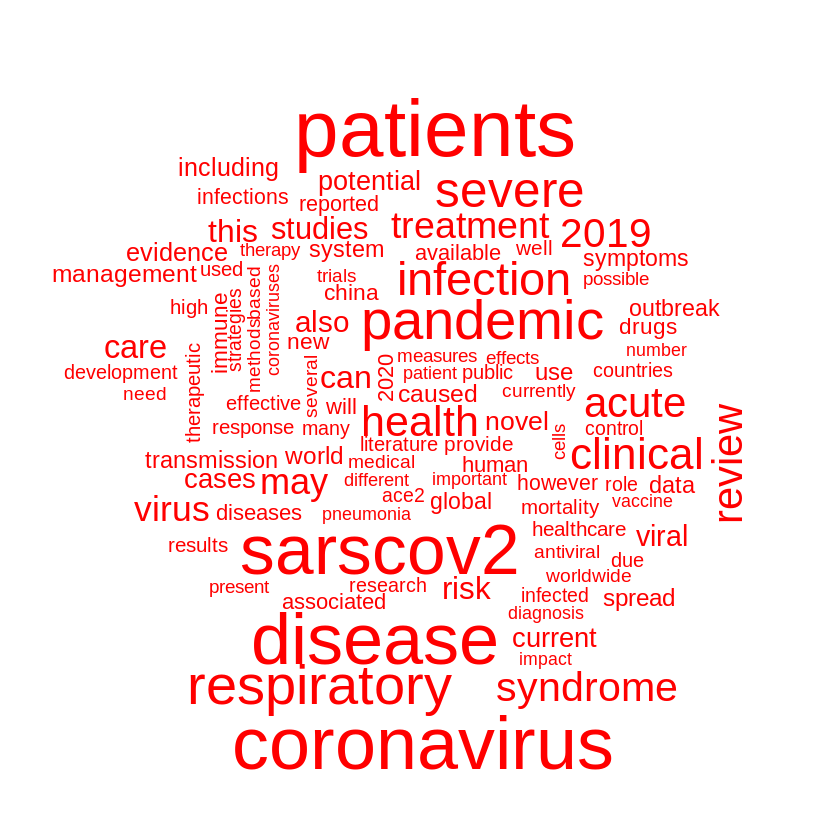

In [15]:
term <- names(term_frequency_covid)
num <- term_frequency_covid
word_freqs <- data.frame(term, num)
wordcloud(word_freqs$term, word_freqs$num, max.words = 100, colors = "red")

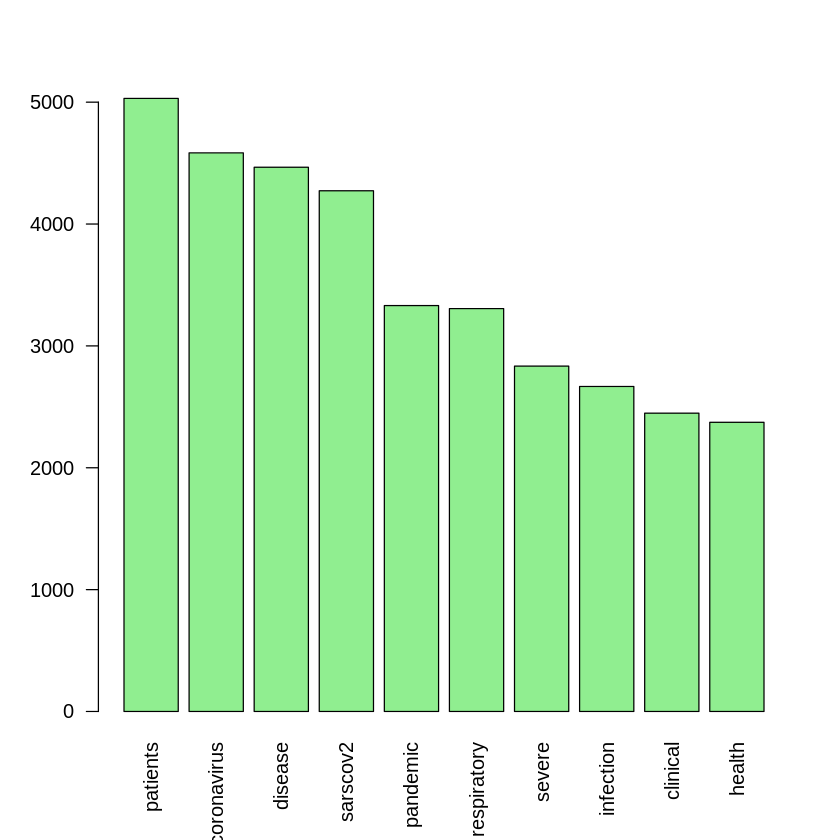

In [16]:
freq <- sort(colSums(as.matrix(covid_dtm)), decreasing=TRUE)   
barplot(freq[1:10],col="lightgreen",las=2)

<<DocumentTermMatrix (documents: 3767, terms: 35)>>
Non-/sparse entries: 46635/85210
Sparsity           : 65%
Maximal term length: 11
Weighting          : term frequency (tf)


Call:
hclust(d = d, method = "complete")

Cluster method   : complete 
Distance         : euclidean 
Number of objects: 35 


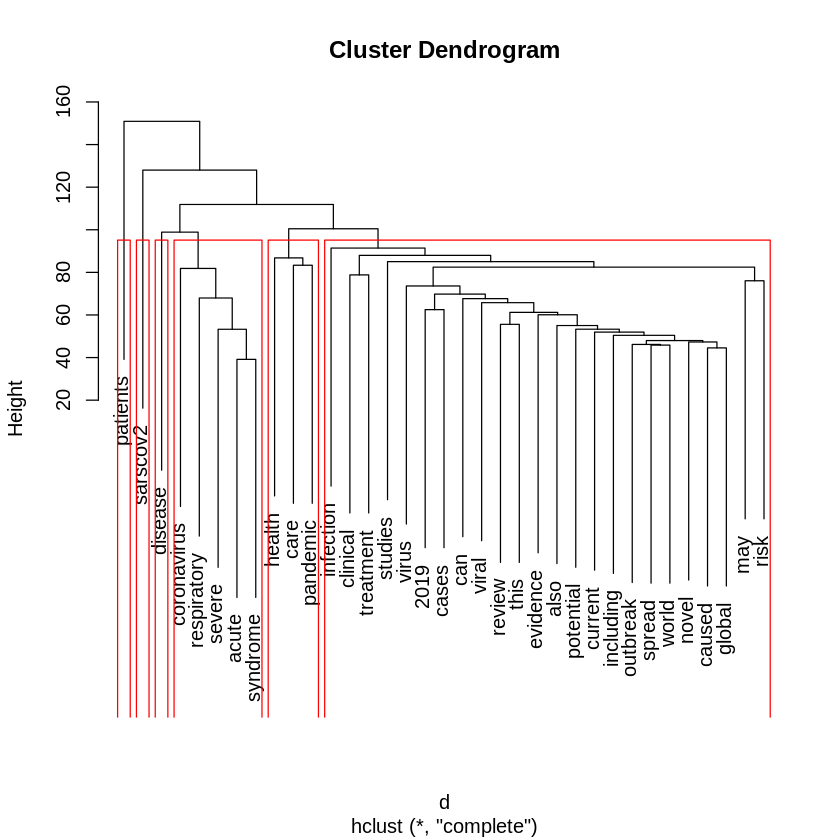

In [17]:
dtmss <- removeSparseTerms(covid_dtm, 0.80)   
dtmss   
d <- dist(t(dtmss), method="euclidian")   
fit <- hclust(d=d, method="complete")
fit 
plot(fit, hang=1) 
groups <- cutree(fit, k=6)   
rect.hclust(fit, k=6, border="red")

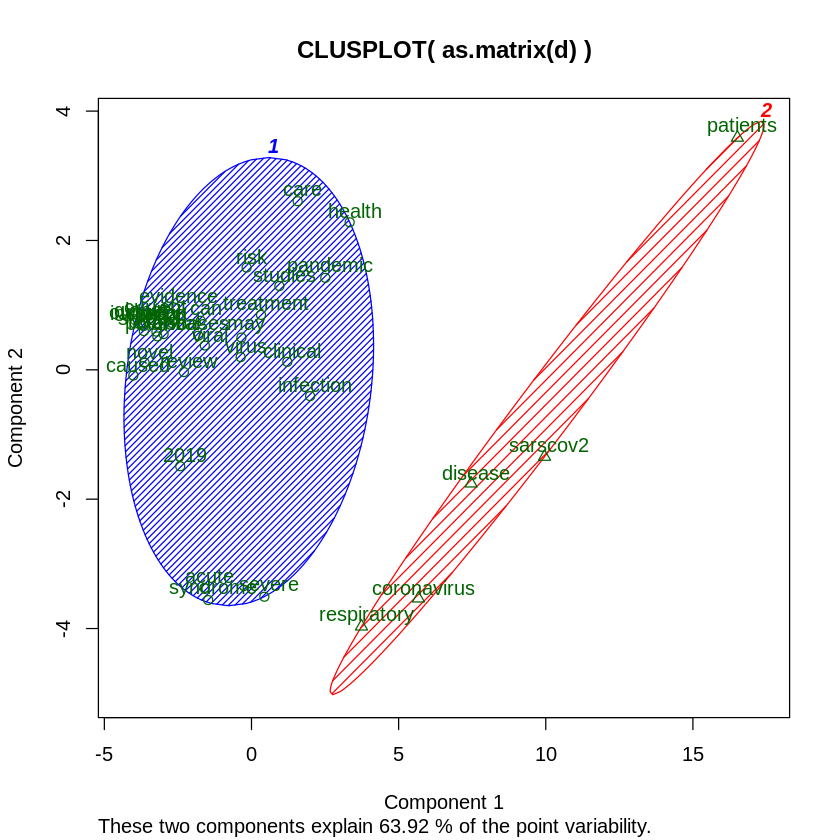

In [18]:
d <- dist(t(dtmss), method="euclidian")   
kfit <- kmeans(d, 2)   
clusplot(as.matrix(d), kfit$cluster, color=T, shade=T, labels=2, lines=0)

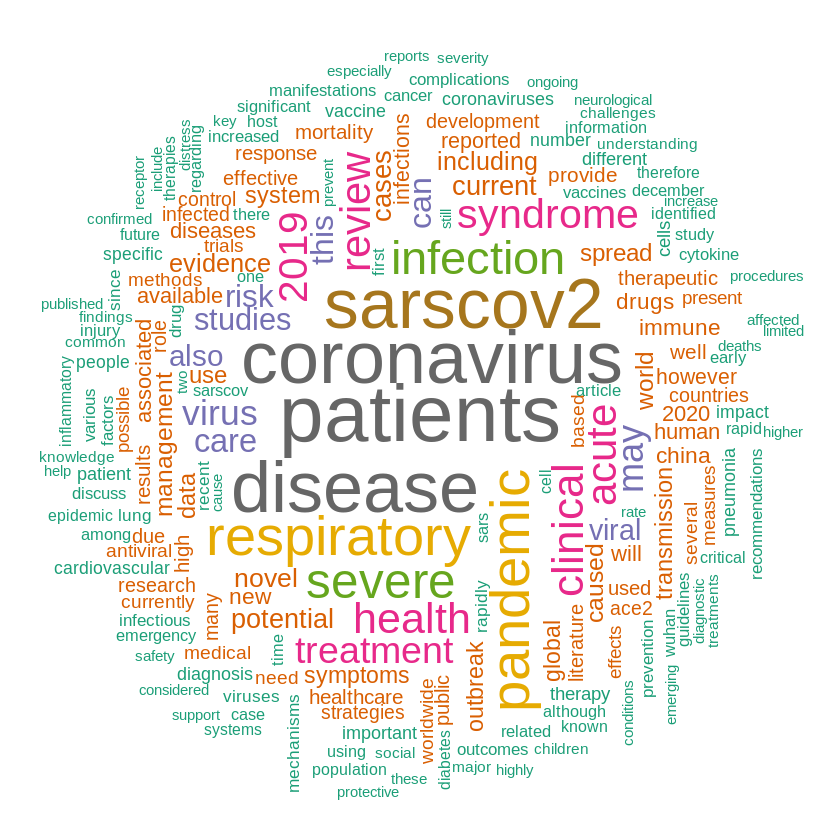

In [19]:
set.seed(1234)
wordcloud(words = word_freqs$term, freq = word_freqs$num, min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))

## Leitura dos dados Tweet Covid19

In [3]:
tweets_covid <-read_csv('covid19_tweets.csv')

Parsed with column specification:
cols(
  user_name = col_character(),
  user_location = col_character(),
  user_description = col_character(),
  user_created = col_datetime(format = ""),
  user_followers = col_double(),
  user_friends = col_double(),
  user_favourites = col_double(),
  user_verified = col_logical(),
  date = col_datetime(format = ""),
  text = col_character(),
  hashtags = col_character(),
  source = col_character(),
  is_retweet = col_logical()
)



In [4]:
glimpse(tweets_covid)

Rows: 179,108
Columns: 13
$ user_name        <chr> "ᏉᎥ☻լꂅϮ", "Tom Basile 🇺🇸", "Time4fisticuffs", "ethel…
$ user_location    <chr> "astroworld", "New York, NY", "Pewee Valley, KY", "S…
$ user_description <chr> "wednesday addams as a disney princess keepin it [̲̅…
$ user_created     <dttm> 2017-05-26 05:46:42, 2009-04-16 20:06:23, 2009-02-2…
$ user_followers   <dbl> 624, 2253, 9275, 197, 101009, 1180, 79956, 608, 25, …
$ user_friends     <dbl> 950, 1677, 9525, 987, 168, 1071, 54810, 355, 29, 342…
$ user_favourites  <dbl> 18775, 24, 7254, 1488, 101, 1287, 3801, 95, 18, 2980…
$ user_verified    <lgl> FALSE, TRUE, FALSE, FALSE, FALSE, FALSE, FALSE, FALS…
$ date             <dttm> 2020-07-25 12:27:21, 2020-07-25 12:27:17, 2020-07-2…
$ text             <chr> "If I smelled the scent of hand sanitizers today on …
$ hashtags         <chr> NA, NA, "['COVID19']", "['COVID19']", "['CoronaVirus…
$ source           <chr> "Twitter for iPhone", "Twitter for Android", "Twitte…
$ is_retweet       <lgl> F

In [5]:
tweets_covid<-tweets_covid %>%select(c(user_location, date, text, source))

In [6]:
tweets_covid%>%head(5)

user_location,date,text,source
<chr>,<dttm>,<chr>,<chr>
astroworld,2020-07-25 12:27:21,"If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0",Twitter for iPhone
"New York, NY",2020-07-25 12:27:17,Hey @Yankees @YankeesPR and @MLB - wouldn't it have made more sense to have the players pay their respects to the A… https://t.co/1QvW0zgyPu,Twitter for Android
"Pewee Valley, KY",2020-07-25 12:27:14,@diane3443 @wdunlap @realDonaldTrump Trump never once claimed #COVID19 was a hoax. We all claim that this effort to… https://t.co/Jkk8vHWHb3,Twitter for Android
Stuck in the Middle,2020-07-25 12:27:10,@brookbanktv The one gift #COVID19 has give me is an appreciation for the simple things that were always around me… https://t.co/Z0pOAlFXcW,Twitter for iPhone
Jammu and Kashmir,2020-07-25 12:27:08,25 July : Media Bulletin on Novel #CoronaVirusUpdates #COVID19 @kansalrohit69 @DrSyedSehrish @airnewsalerts @ANI… https://t.co/MN0EEcsJHh,Twitter for Android


In [7]:
tweets_covid%>%tail(5)

user_location,date,text,source
<chr>,<dttm>,<chr>,<chr>
"Ilorin, Nigeria",2020-08-29 19:44:21,"Thanks @IamOhmai for nominating me for the @WHO #WearAMask challenge. I nominate @abdlbaasit_ @hvbxxb,… https://t.co/IegQDkKudT",Twitter for Android
Ontario,2020-08-29 19:44:16,2020! The year of insanity! Lol! #COVID19 https://t.co/y48NP0yzgn,Twitter for Android
🇨🇦 Canada,2020-08-29 19:44:15,@CTVNews A powerful painting by Juan Lucena. It's a tribute to the grandparents who died of COVID 19 and the grandc… https://t.co/wnXbbyoCe2,Twitter Web App
New York City,2020-08-29 19:44:14,"More than 1,200 students test positive for #COVID19 at major university - ABC News https://t.co/6aNhSiF5gh",Twitter for iPhone
"Aliwal North, South Africa",2020-08-29 19:44:08,I stop when I see a Stop @SABCNews @IzindabaNews24 @dailysunsa @eNCA @AliwalNorth @Ambitiouz_Ent @Official_SABC1… https://t.co/ReG8pwZoN7,Twitter for Android


In [8]:
tweets_covid<-head(tweets_covid,5000)

In [9]:
# definindo a fonte texto tweets
tweets_covid_source <- VectorSource(tweets_covid$text)
# transformando em corpus texto tweets
tweets_covid_corpus <- VCorpus(tweets_covid_source)

In [10]:
print(tweets_covid_corpus)
tweets_covid_corpus[[1]]
tweets_covid_corpus[[1]]$content

<<VCorpus>>
Metadata:  corpus specific: 0, document level (indexed): 0
Content:  documents: 5000


<<PlainTextDocument>>
Metadata:  7
Content:  chars: 140

[1] "If I smelled the scent of hand sanitizers today on someone in the past, I would think they were so intoxicated that… https://t.co/QZvYbrOgb0"

## Aplicando a limpeza e normalização dos dados em toda base Pub Med

In [11]:
remover_https_url <-function(texto)gsub("https.*","",  texto)
remover_http_url <-function(texto)gsub("http.*","",  texto)
remover_barra <-function(texto)gsub("/", "", texto)
remover_barras <-function(texto)gsub("\\|", "", texto)
remover_arroba <-function(texto)gsub("@", "", texto)
tweets_covid_corpus <-tm_map(tweets_covid_corpus, content_transformer(remover_https_url))
tweets_covid_corpus <-tm_map(tweets_covid_corpus, content_transformer(remover_http_url))
tweets_covid_corpus <-tm_map(tweets_covid_corpus, content_transformer(remover_barra))
tweets_covid_corpus <-tm_map(tweets_covid_corpus, content_transformer(remover_barras))
tweets_covid_corpus <-tm_map(tweets_covid_corpus, content_transformer(remover_arroba))                                                        
tweets_covid_corpus <-tm_map(tweets_covid_corpus, content_transformer(removePunctuation))
tweets_covid_corpus <-tm_map(tweets_covid_corpus, content_transformer(removeNumbers))
tweets_covid_corpus <-tm_map(tweets_covid_corpus, removeWords, words = c(new_stops))
tweets_covid_corpus <-tm_map(tweets_covid_corpus, content_transformer(stripWhitespace))
tweets_covid_corpus[[1]]$content

[1] "If I smelled scent hand sanitizers today someone past I think intoxicated … "

In [12]:
tweet_covid_dtm <- DocumentTermMatrix(tweets_covid_corpus)
tweet_covid_dtm

<<DocumentTermMatrix (documents: 5000, terms: 14066)>>
Non-/sparse entries: 48016/70281984
Sparsity           : 100%
Maximal term length: 58
Weighting          : term frequency (tf)

In [14]:
tweet_covid_tdm <- TermDocumentMatrix(tweets_covid_corpus)
tweet_covid_tdm

<<TermDocumentMatrix (terms: 14066, documents: 5000)>>
Non-/sparse entries: 48016/70281984
Sparsity           : 100%
Maximal term length: 58
Weighting          : term frequency (tf)

In [15]:
tweet_covid_m1 <- as.matrix(tweet_covid_dtm)

In [16]:
tweet_covid_m2 <- as.matrix(tweet_covid_tdm)

In [17]:
tweet_covid_m1[1:10, 1000:1010]

,argue,argues,argument,argumentum,argus,arikthebuilder,arise,arizona,arizona…,arizona’s,arleneainsley
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,0


In [18]:
tweet_covid_m2[1000:1010, 1:10]

,1,2,3,4,5,6,7,8,9,10
argue,0,0,0,0,0,0,0,0,0,0
argues,0,0,0,0,0,0,0,0,0,0
argument,0,0,0,0,0,0,0,0,0,0
argumentum,0,0,0,0,0,0,0,0,0,0
argus,0,0,0,0,0,0,0,0,0,0
arikthebuilder,0,0,0,0,0,0,0,0,0,0
arise,0,0,0,0,0,0,0,0,0,0
arizona,0,0,0,0,0,0,0,0,0,0
arizona…,0,0,0,0,0,0,0,0,0,0
arizona’s,0,0,0,0,0,0,0,0,0,0


In [33]:
freq.terms <- findFreqTerms(tweet_covid_tdm, lowfreq = 20)
freq.terms[1:100]

[1] "’re"                 "across"              "active"             
  [4] "affected"            "africa"              "air"                
  [7] "alert"               "all"                 "already"            
 [10] "alreadyvideo"        "also"                "america"            
 [13] "americans"           "amid"                "amp"                
 [16] "and"                 "announced"           "another"            
 [19] "anyone"              "app"                 "are"                
 [22] "around"              "available"           "away"               
 [25] "back"                "best"                "better"             
 [28] "big"                 "bjp"                 "blood"              
 [31] "borisjohnson"        "breaking"            "business"           
 [34] "businesses"          "but"                 "call"               
 [37] "can"                 "cant"                "care"               
 [40] "case"                "cases"               "center"             
 [43] "challenging"         "check"               "chief"              
 [46] "children"            "china"               "cnn"                
 [49] "come"                "community"           "confirmed"          
 [52] "contact"             "control"             "corona"             
 [55] "coronainfoch"        "coronavirus"         "coronavirus…"       
 [58] "coronaviruspandemic" "coronavirusupdate"   "countries"          
 [61] "country"             "covid"               "covid…"             
 [64] "crisis"              "daily"               "data"               
 [67] "day"                 "days"                "dead"               
 [70] "death"               "deaths"              "despite"            
 [73] "died"                "distancing"          "don’t"              
 [76] "done"                "dont"                "due"                
 [79] "early"               "economic"            "education"          
 [82] "england"             "enough"              "especially"         
 [85] "even"                "ever"                "every"              
 [88] "everyone"            "evidence"            "expert"             
 [91] "experts"             "face"                "facemask"           
 [94] "families"            "family"              "far"                
 [97] "father"              "feel"                "fight"              
[100] "find"

In [36]:
term_frequency_tweet_covid <- rowSums(tweet_covid_m2)
term_frequency_tweet_covid <- sort(term_frequency_tweet_covid, decreasing = TRUE)
head(term_frequency_tweet_covid, 100) 
term_frequency_tweet_covid[100:200]

covid           cases             new     coronavirus             amp 
            627             525             396             386             296 
         people            will             can        pandemic          health 
            250             247             194             191             185 
           help             now        positive          spread             get 
            185             168             156             145             142 
         deaths             one            this           daily            even 
            141             138             138             137             135 
           july            risk            mask            just            need 
            133             129             127             126             122 
          total           today        symptoms            like            many 
            120             110             109             108             102 
           time            slow             day           masks        identify 
            100              99              98              97              93 
         sooner          tested            back   selfreporting      government 
             91              91              90              90              87 
       patients         testing           tests             how          number 
             84              84              83              82              82 
          first          please            wear          update            good 
             81              80              80              79              78 
       lockdown            days           still realdonaldtrump            news 
             78              77              77              76              75 
          india            last            dont            face            care 
             74              74              73              73              70 
          world             you            read             due            know 
             70              70              69              68              68 
            see        hospital        reported           trump          corona 
             68              67              67              65              63 
         latest            safe           since            test            home 
             63              63              63              63              62 
          death             our            work           going             its 
             61              61              60              59              59 
        million            what             not         vaccine            well 
             59              59              58              58              58 
        support            want          around       confirmed            take 
             57              57              56              56              55 
          virus             why             may          social           great 
             55              55              54              54              53 
           keep         another           fight            stay           don’t 
             53              52              52              52              51

don’t                year                case                data 
                 51                  51                  50                  50 
                for              global           recovered              school 
                 50                  50                  50                  49 
                way                make                says               state 
                 49                  48                  48                  48 
            reports               check               every                free 
                 47                  46                  46                  46 
               much            response               there               think 
                 46                  46                  46                  46 
            wearing                with                best                high 
                 46                  46                  45                  45 
               life              public                rate                said 
                 45                  45                  45                  45 
                who              months              plasma               right 
                 45                  44                  44                  44 
            country                live            business                 but 
                 43                  43                  42                  42 
             follow              impact                more             schools 
                 42                  42                  42                  42 
                via               video                 and              family 
                 42                  42                  41                  41 
           children                must            recovery                also 
                 40                  40                  40                  39 
          countries                week                 man                next 
                 39                  39                  38                  38 
             record           situation              states              taking 
                 38                  38                  38                  38 
            workers              active              better               blood 
                 38                  37                  37                  37 
               kids                look             weekend                your 
                 37                  37                  37                  37 
coronaviruspandemic                died               hours               local 
                 36                  36                  36                  36 
               long              really             sarscov            saturday 
                 36                  36                  36                  36 
               stop                they               times                xavi 
                 36                  36                  36                  36 
             crisis             getting                 gmt                when 
                 35                  35                  35                  35 
               ever            everyone                 far                 got 
                 34                  34                  34                  34 
            highest               lives                 per                amid 
                 34                  34                  34                  33 
             father              police                post               share 
                 33                  33                  33                  33 
                th…               watch                love                 two 
                 33                  33                  32                  32 
             covid…           important             protect              report 
                 31                  31      

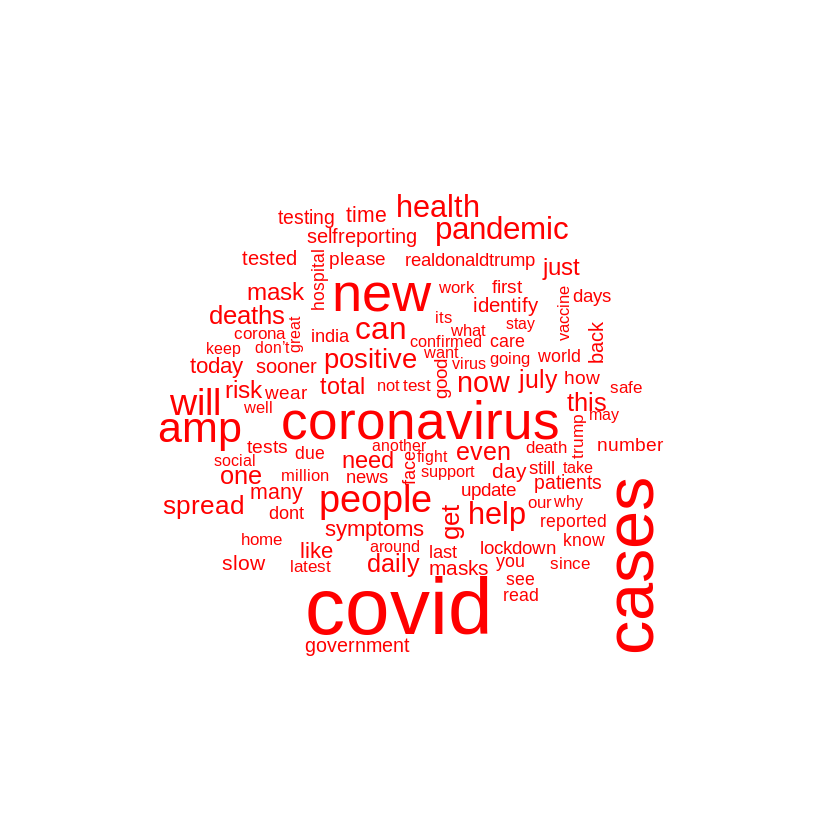

In [37]:
term <- names(term_frequency_tweet_covid)
num <- term_frequency_tweet_covid
word_freqs <- data.frame(term, num)
wordcloud(word_freqs$term, word_freqs$num, max.words = 100, colors = "red")

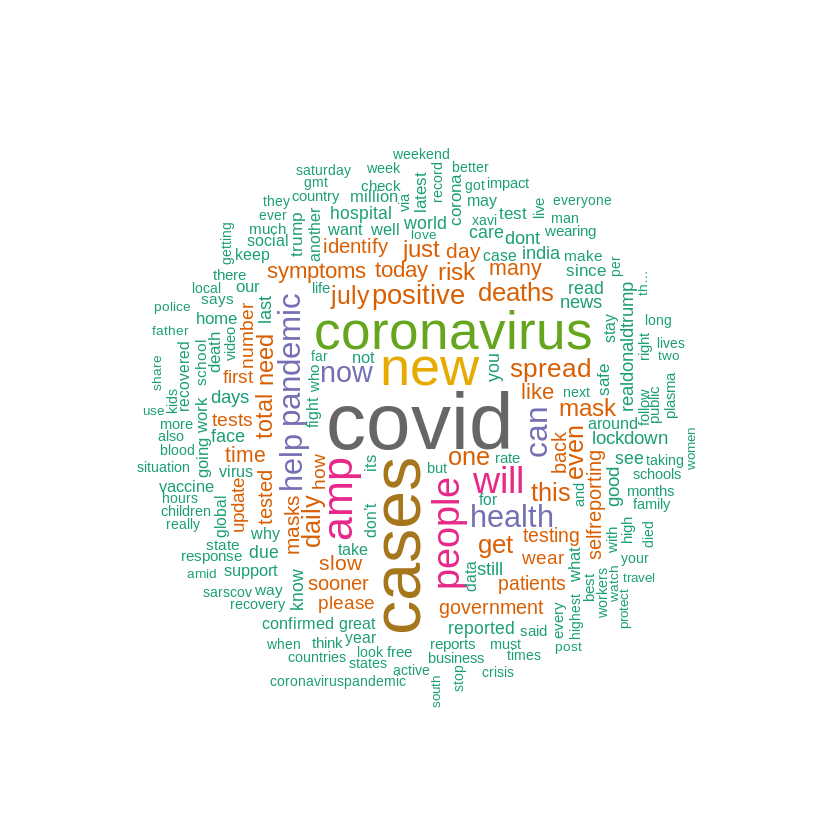

In [38]:
set.seed(1234)
wordcloud(words = word_freqs$term, freq = word_freqs$num, min.freq = 1,
          max.words=200, random.order=FALSE, rot.per=0.35, 
          colors=brewer.pal(8, "Dark2"))

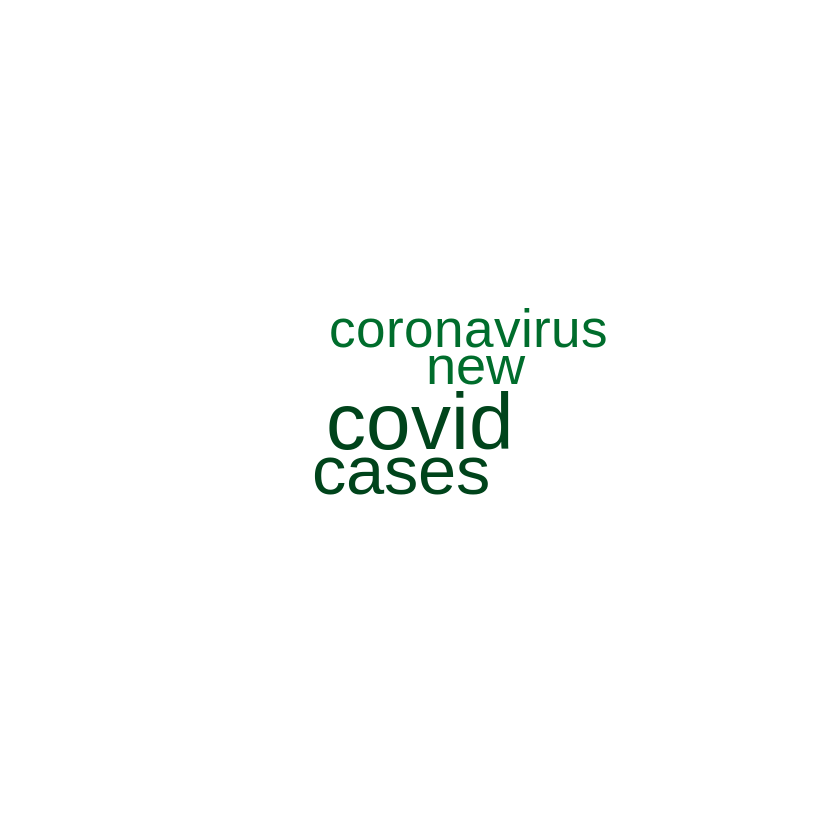

In [43]:
word.freq <- sort(rowSums(tweet_covid_m2), decreasing = T)
pal <- brewer.pal(9, "BuGn")[-(1:4)]
wordcloud(words = names(word.freq), freq = word.freq, min.freq = 300,
    random.order = F, colors = pal)

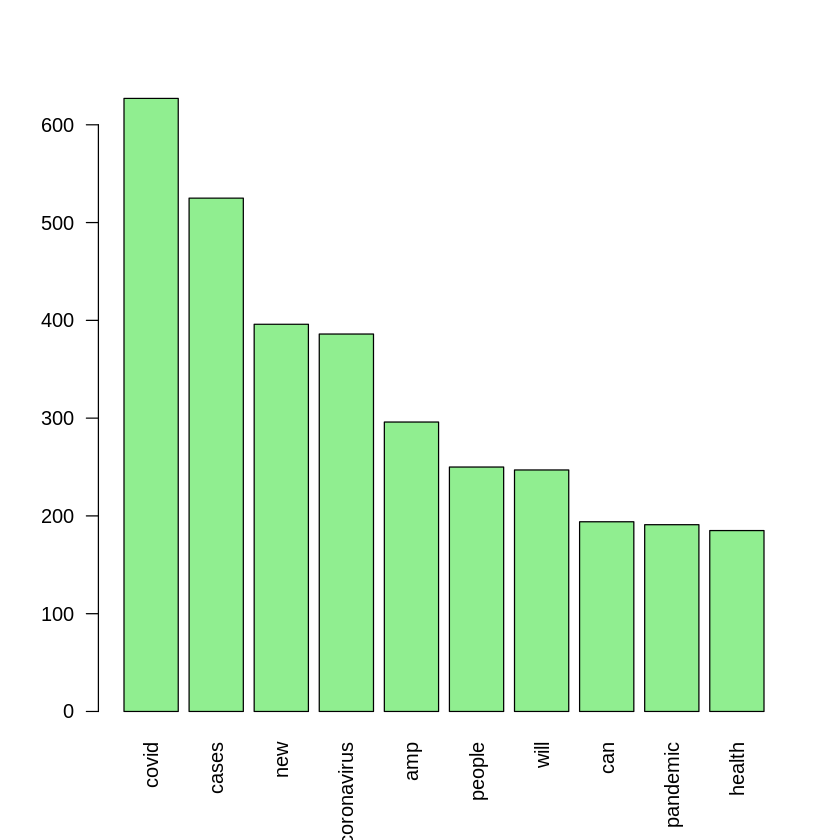

In [39]:
freq <- sort(colSums(tweet_covid_m1), decreasing=TRUE)   
barplot(freq[1:10],col="lightgreen",las=2)